In [1]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from IPython.display import display,Markdown

import numpy as np
import math
from scipy.integrate import solve_ivp
from hjb import *

from math import *

# reverse tree works quite badly without integration

INTEGRATE = False
#INTEGRATE = True
INTEGRATION_REL_TOLERANCE = 1e-2
INTEGRATION_ABS_TOLERANCE = 1e-4

coeff = 2.25

class PIPDynamics(DynamicSystem):
    """
        The state space is (L, Ldot, theta, thetadot) and the control is the external force 
    """
    def __init__(self, g=9.81):
        self.g = g
    def dynamics(self, state, control):
        """
            This function calculates PIP's system dynamics according to the current state and control
        """
        L = state[0]   
        Ldot= state[1]
        theta = state[2]
        thetadot = state[3]
        u = control                    # Here u is already the effective control stands for L's acceleration. 
        
        EoM = [0]*4
        
        EoM[0] = Ldot
        EoM[1] = u
        EoM[2] = thetadot
        EoM[3] = self.g/L * sin(theta) - 2.0 * thetadot * Ldot/L
        
        return np.array(EoM)
    def nextState(self,state,control,dt):
        if dt < 0:
            #allow reverse dynamics
            if INTEGRATE:
                res = solve_ivp((lambda t,y:-self.dynamics(y,control)),[0,-dt],state,rtol=INTEGRATION_REL_TOLERANCE,atol=INTEGRATION_ABS_TOLERANCE)
                x = res.y[:,-1]
            else:
                x = state + dt*self.dynamics(state,control)
        else:
            if INTEGRATE:
                res = solve_ivp((lambda t,y:self.dynamics(y,control)),[0,dt],state,rtol=INTEGRATION_REL_TOLERANCE,atol=INTEGRATION_ABS_TOLERANCE)
                x = res.y[:,-1]
            else:
                x = state + dt*self.dynamics(state,control)
        #normalize the angle for this model it is the third angle.
        x[2] = x[2]%(2.0*math.pi)
        if x[0] < 0:
            x[0] += (2.0*math.pi)
        return x
    
    def validState(self,state):
        return True

    def validControl(self,state,control):
        return True

class PendulumControlSampler(ControlSampler):
    # This part gives the control to the pip model.
    # The output from this function should be the robot's external contact force.
    def __init__(self, lmin, lmax, g, dt):
        self.lmin = lmin    # Lower length bound
        self.lmax = lmax    # Higher length bound
        self.g = g;
        self.dt = dt
    def sample(self,state):
        # Based on the physical meaning of the contact force, it should always be supportive so the minimal value is 0
        # As for the maximum value, according to the observation of robot jump behavior, a linear maximum force is assumed.
        L = state[0]
        Ldot = state[1]
        theta = state[2]
        thetadot = state[3]
        
        # The control will be directly assigned to the pendulum length state variable.        
        u_min = -self.g * cos(theta)        
        u_max = coeff * self.g * cos(theta) - coeff * self.g * cos(theta)/(self.lmax - self.lmin) * (L-self.lmin)
        if u_min>0:
            u_min = 0.0
        if u_max<0:
            u_max = 0.0
        return [u_min, 0, u_max]

class PIPObjectiveFunction(ObjectiveFunction):
    def edgeCost(self, state, control, dt, nextState):
        # The cost is defined as follows
        # The main purpose is that according to the dynamics integration, the robot's next state should geometrically change as little as possible.
        L_k = state[0]
        Ldot_k = state[1]
        theta_k = state[2]
        thetadot_k = state[3]
        
        u = control
        cost = abs(dt)
        return cost
    
class TimeObjectiveFunction(ObjectiveFunction):
    def edgeCost(self,state,control,dt,nextState):
        return abs(dt)
    
class EffortObjectiveFunction(ObjectiveFunction):
    def edgeCost(self,state,control,dt,nextState):
        return np.linalg.norm(control)**2*dt

def GoalFunc(x):
    # This function is used to categorize whether the given state is a goal state or not
    L_k = x[0]
    Ldot_k = x[1]
    theta_k = x[2]
    thetadot_k = x[3]
    # As long as the pendulum is on the positive side and it is angular velocity is positive.
    Res = True
#     if(theta_k>0) and (thetadot_k>=0) and (Ldot_k>=0):
    if(theta_k>0) and (thetadot_k>=0):
        Res = True
    else:
        Res = False
    return Res

In [98]:
#create the dynamics function, terminal conditions, and control bounds
g = 9.81

dynamics = PIPDynamics(g)
L0 = 0.7
Ldot0 = 0.0
Theta0 = math.pi*1.0/4.0
Thetadot0 = -1.0

# L0, Ldot0, Theta0, Thetadot0
start = np.array([L0, Ldot0, Theta0, Thetadot0])    
xsample = start    # This is used for debugging purpose.

LLow = 0.35;                  LUpp = 1.05;
LdotLow = -1.0;               LdotUpp = 1.0;
ThetaLow = -math.pi/6.0;      ThetaUpp = math.pi/2.0;
ThetadotLow = -1.5;           ThetadotUpp = -1.0 * ThetadotLow;

L_List = np.linspace(LLow, LUpp, num=L_Grids)
Ldot_List = np.linspace(LdotLow, LdotUpp, num=Ldot_Grids)
Theta_List = np.linspace(ThetaLow, ThetaUpp, num=Theta_Grids)
Thetadot_List = np.linspace(ThetadotLow, ThetadotUpp, num=Thetadot_Grids)

L_unit = (LUpp - LLow)/(1.0 * L_Grids - 1.0)
Ldot_unit = (LdotUpp - LdotLow)/(1.0 * Ldot_Grids - 1.0)
Theta_unit = (ThetaUpp - ThetaLow)/(1.0 * Theta_Grids - 1.0)
Thetadot_unit = (ThetadotUpp - ThetadotLow)/(1.0 * Thetadot_Grids - 1.0)

bounds = [(LLow, LUpp), (LdotLow, LdotUpp), (ThetaLow, ThetaUpp), (ThetadotLow, ThetadotUpp)]

dt = 0.1   # Simulation time step length

controlSampler = PendulumControlSampler(LLow, LUpp, g, dt)
objective = TimeObjectiveFunction()

In [3]:
#some debugging of the dynamics function
print "NextState from xsample, 0.1s",dynamics.nextState(xsample,0, 0.1)
print "NextState from xsample, 0.5s",dynamics.nextState(xsample,0, 0.5)
x = xsample
t = 0
while t < 0.5:
    x = dynamics.nextState(x,0,0.01)
    t += 0.01
print "Euler integration 0.5s, 0.01s substep",x
print "Reverse 0.1s",dynamics.nextState(xsample,0,-0.1)
print "Forward then reverse 0.1s",dynamics.nextState(dynamics.nextState(xsample,0,0.1),0,-0.1)
print "Reverse then forward 0.1s",dynamics.nextState(dynamics.nextState(xsample,0,-0.1),0,0.1)
print "Forward then reverse 0.1s",dynamics.nextState(dynamics.nextState(xsample,0.0,0.1),0.0,-0.1)
print "Reverse then forward 0.1s",dynamics.nextState(dynamics.nextState(xsample,0.0,-0.1),0.0,0.1)

NextState from xsample, 0.1s [ 0.7         0.          0.68539816 -0.00904035]
NextState from xsample, 0.5s [0.7        0.         0.28539816 3.95479823]
Euler integration 0.5s, 0.01s substep [0.7        0.         1.51537485 4.4451184 ]
Reverse 0.1s [ 0.7         0.          0.88539816 -1.99095965]
Forward then reverse 0.1s [ 0.7         0.          0.6863022  -0.89611844]
Reverse then forward 0.1s [ 0.7         0.          0.6863022  -0.90601978]
Forward then reverse 0.1s [ 0.7         0.          0.6863022  -0.89611844]
Reverse then forward 0.1s [ 0.7         0.          0.6863022  -0.90601978]


In [4]:
#testing the RobustRegularGridInterpolator
xdivs = np.array([0,1,2])
ydivs = np.array([0,1,2])
values = np.arange(9,dtype=float).reshape((3,3))
values[0,0] = float('inf')
values[0,1] = float('inf')
print values
grid = RobustRegularGridInterpolator((xdivs,ydivs),values)
print grid([0.1,0.5]),"should be inf"
print grid([0.6,0.5]),"should be 3.5"

[[inf inf  2.]
 [ 3.  4.  5.]
 [ 6.  7.  8.]]
3.5 should be inf
3.5 should be 3.5


In [5]:
L_Grids = 71
Ldot_Grids = 21
Theta_Grids = 211
Thetadot_Grids = 31

hjb = HJBSolver(dynamics, controlSampler, dt, objective,
                bounds, [L_Grids, Ldot_Grids, Theta_Grids, Thetadot_Grids],
                GoalFunc)

scell = hjb.stateToCell(start)
print bounds
print "Start cell",scell
print "Start cell center",hjb.cellToCenterState(scell)
print "cell of Start cell center",hjb.stateToCell(hjb.cellToCenterState(scell))
hjb.value[scell] = 0
print "Start interpolator index",hjb.valueInterpolator.getCell(start)
print "Start interpolator value",hjb.valueInterpolator(start)
print "Start cell center interpolator index",hjb.valueInterpolator.getCell(hjb.cellToCenterState(scell))
print "Start cell center interpolator value",hjb.valueInterpolator(hjb.cellToCenterState(scell))


[(0.35, 1.05), (-1.0, 1.0), (-0.5235987755982988, 1.5707963267948966), (-1.5, 1.5)]
Start cell (35, 10, 131, 5)
Start cell center [ 0.7         0.          0.7816759  -0.96774194]
cell of Start cell center (35, 10, 131, 5)
Start interpolator index [34, 9, 131, 4]
Start interpolator value 0.0
Start cell center interpolator index [34, 9, 130, 4]
Start cell center interpolator value 0.0


hjb.py:176: RuntimeWarning: invalid value encountered in multiply
  vcell = (1-u)*vcelldim0 + u*vcelldim1


# HJB Solver

<IPython.core.display.Javascript object>


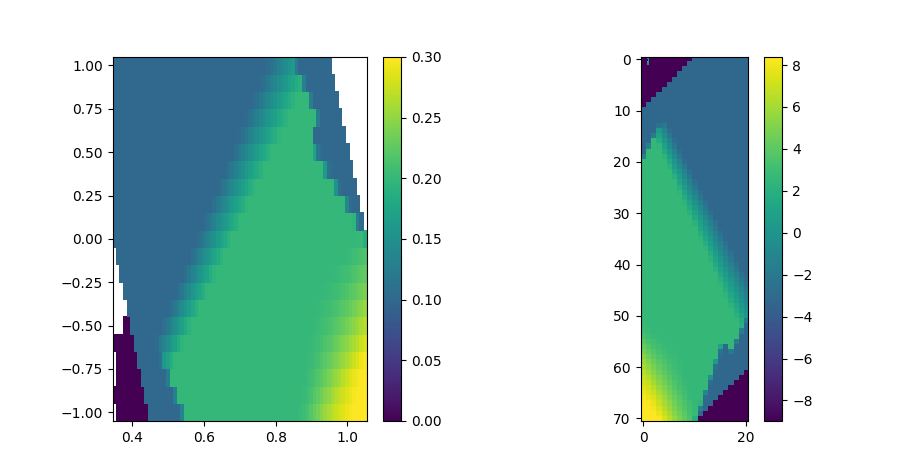

aW50ZXJhY3RpdmUoY2hpbGRyZW49KEludFNsaWRlcih2YWx1ZT0wLCBkZXNjcmlwdGlvbj11J3hpbmRleCcsIG1heD0zKSwgT3V0cHV0KCkpLCBfZG9tX2NsYXNzZXM9KHUnd2lkZ2V0LWludGXigKY=


aW50ZXJhY3RpdmUoY2hpbGRyZW49KEludFNsaWRlcih2YWx1ZT0xLCBkZXNjcmlwdGlvbj11J3lpbmRleCcsIG1heD0zKSwgT3V0cHV0KCkpLCBfZG9tX2NsYXNzZXM9KHUnd2lkZ2V0LWludGXigKY=


IntSlider(value=0, description=u'Ref cell 0', max=70)

IntSlider(value=0, description=u'Ref cell 1', max=20)

IntSlider(value=0, description=u'Ref cell 2', max=210)

IntSlider(value=0, description=u'Ref cell 3', max=30)

aW50ZXJhY3RpdmUoY2hpbGRyZW49KEludFNsaWRlcih2YWx1ZT0xMSwgZGVzY3JpcHRpb249dSdpJywgbWF4PTEwMSwgbWluPTEsIHN0ZXA9MTApLCBCdXR0b24oZGVzY3JpcHRpb249dSdSdW7igKY=


In [6]:
#need to set dt large enough to have a chance to jump cells
#hjb = HJBSolver(dynamics, controlSampler, dt, objective, bounds, [200,240], goal=goal)
display(Markdown("# HJB Solver"))
hjbdisplay = GridCostFunctionDisplay(hjb,hjb.value,hjb.policy,policyDims=None)
hjbdisplay.show()

def do_value_iteration(i):
    print "Running",i,"HJB iterations"
    hjb.valueIteration(iters=i)
    hjbdisplay.refresh(hjb.value,hjb.policy)
    if hjb.getPolicy(start) is not None:
        #show the HJB policy 
        xs,us = rolloutPolicy(dynamics,start,(lambda x:hjb.getPolicy(x)),dt*0.5,200)
        hjbdisplay.plotTrajectory(xs,color='r',zorder=3)
        
        la_policy = LookaheadPolicy(dynamics,dt,controlSampler,objective,(lambda x:False),hjb.interpolateValue)
        xs,us = rolloutPolicy(dynamics,start,la_policy,dt,200)
        hjbdisplay.plotTrajectory(xs,color='y',zorder=4)
    hjbdisplay.plotFlow(lambda x:hjb.getPolicy(x))
interact_manual(do_value_iteration,i=widgets.IntSlider(min=1, max=101, step=10, value=11));


# Backward Solver

<IPython.core.display.Javascript object>


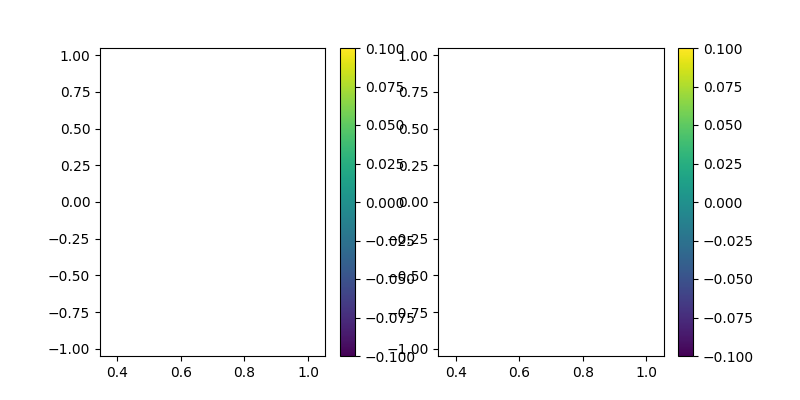

aW50ZXJhY3RpdmUoY2hpbGRyZW49KEludFNsaWRlcih2YWx1ZT0wLCBkZXNjcmlwdGlvbj11J3hpbmRleCcsIG1heD0zKSwgT3V0cHV0KCkpLCBfZG9tX2NsYXNzZXM9KHUnd2lkZ2V0LWludGXigKY=


aW50ZXJhY3RpdmUoY2hpbGRyZW49KEludFNsaWRlcih2YWx1ZT0xLCBkZXNjcmlwdGlvbj11J3lpbmRleCcsIG1heD0zKSwgT3V0cHV0KCkpLCBfZG9tX2NsYXNzZXM9KHUnd2lkZ2V0LWludGXigKY=


IntSlider(value=0, description=u'Ref cell 0', max=70)

IntSlider(value=0, description=u'Ref cell 1', max=20)

IntSlider(value=0, description=u'Ref cell 2', max=210)

IntSlider(value=0, description=u'Ref cell 3', max=30)

aW50ZXJhY3RpdmUoY2hpbGRyZW49KEludFNsaWRlcih2YWx1ZT0xMDAxLCBkZXNjcmlwdGlvbj11J04nLCBtYXg9MTAwMDEsIG1pbj0xLCBzdGVwPTEwMCksIEJ1dHRvbihkZXNjcmlwdGlvbj3igKY=


In [17]:
#this does backward search with a TreeSolver
# bwtree = OptimalControlTreeSolver(dynamics,controlSampler,-dt*0.5,objective, bounds,[50,60], start=goal,goal=(lambda x:False),terminalAsStartCost=True)
bwtree = OptimalControlTreeSolver(dynamics,controlSampler,-dt*0.5,objective,
                bounds,[L_Grids, Ldot_Grids, Theta_Grids, Thetadot_Grids],
                start,GoalFunc,terminalAsStartCost=True)
bwtree.maxVisitedPerCell = 10

display(Markdown("# Backward Solver"))
bwtreedisplay = GridCostFunctionDisplay(bwtree,bwtree.costToCome(),bwtree.reversePolicy(),policyDims=None)
bwtreedisplay.show()

def do_bw_search(N):
    for i in range(N):
        bwtree.search_step()
    #bwtree.search()
    print "Generated",bwtree.num_nodes(),"nodes"
    bwtreedisplay.refresh(bwtree.costToCome(),bwtree.reversePolicy())

    if bwtree.getReversePolicy(start) is not None:
        xs,us = rolloutPolicy(dynamics,start,(lambda x:bwtree.getReversePolicy(x)),-bwtree.dt,200)
        bwtreedisplay.plotTrajectory(xs,color='r',zorder=3)
        
        ctc_interp = bwtree.costToComeInterpolator()
        #la_policy = LookaheadPolicy(dynamics,-bwtree.dt,bwtree.controlSampler,bwtree.objective,(lambda x:False),bwtree.getCostToCome)
        la_policy = LookaheadPolicy(dynamics,-bwtree.dt,bwtree.controlSampler,bwtree.objective,(lambda x:False),ctc_interp)
        xs,us = rolloutPolicy(dynamics,start,la_policy,-bwtree.dt,200)
        bwtreedisplay.plotTrajectory(xs,color='y',zorder=4)
    else:
        #bwtreedisplay.plotGraph(color='r',lw='0.5')
        pass

    
interact_manual(do_bw_search,N=widgets.IntSlider(min=1, max=10001, step=100, value=1001));



# Forward Solver

<IPython.core.display.Javascript object>


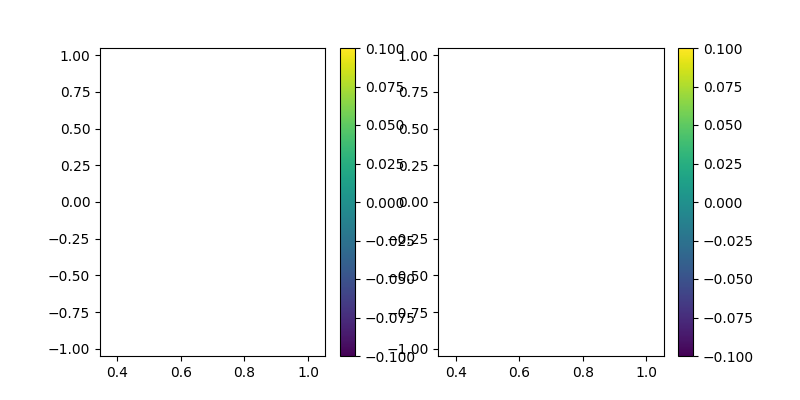

aW50ZXJhY3RpdmUoY2hpbGRyZW49KEludFNsaWRlcih2YWx1ZT0wLCBkZXNjcmlwdGlvbj11J3hpbmRleCcsIG1heD0zKSwgT3V0cHV0KCkpLCBfZG9tX2NsYXNzZXM9KHUnd2lkZ2V0LWludGXigKY=


aW50ZXJhY3RpdmUoY2hpbGRyZW49KEludFNsaWRlcih2YWx1ZT0xLCBkZXNjcmlwdGlvbj11J3lpbmRleCcsIG1heD0zKSwgT3V0cHV0KCkpLCBfZG9tX2NsYXNzZXM9KHUnd2lkZ2V0LWludGXigKY=


IntSlider(value=0, description=u'Ref cell 0', max=70)

IntSlider(value=0, description=u'Ref cell 1', max=20)

IntSlider(value=0, description=u'Ref cell 2', max=210)

IntSlider(value=0, description=u'Ref cell 3', max=30)

aW50ZXJhY3RpdmUoY2hpbGRyZW49KEludFNsaWRlcih2YWx1ZT0xMDAxLCBkZXNjcmlwdGlvbj11J04nLCBtYXg9MTAwMDEsIG1pbj0xLCBzdGVwPTEwMCksIEJ1dHRvbihkZXNjcmlwdGlvbj3igKY=


In [18]:
#this does forward search
tree = OptimalControlTreeSolver(dynamics,controlSampler,dt,objective,
                bounds,[L_Grids, Ldot_Grids, Theta_Grids, Thetadot_Grids],
                start=start,goal=GoalFunc)
tree.maxVisitedPerCell = 5


display(Markdown("# Forward Solver"))
treedisplay = GridCostFunctionDisplay(tree,tree.costToCome(),tree.reversePolicy(),policyDims=None)
treedisplay.show()

def do_fw_search(N):
    for i in range(N):
        tree.search_step()
    treedisplay.refresh(tree.costToCome(),tree.reversePolicy())

    path = tree.result_path()
    if tree.goal is not None:
        assert len(path) > 0
    if len(path) > 0:
        if len(path[0].state)==0:
            path = path[1:]
        if path[-1].state == None:
            path = path[:-1]
        xs = np.array([n.state for n in path])
        treedisplay.plotTrajectory(xs,color='r',zorder=3)

interact_manual(do_fw_search,N=widgets.IntSlider(min=1, max=10001, step=100, value=1001));


In [7]:
import pickle
f = open("hjb_0.txt","w")
pickle.dump(hjb.value,f)
pickle.dump(hjb.policy,f)
f.close()

In [7]:
f = open("hjb_0.txt","r")
value = pickle.load(f)
policy = pickle.load(f)
f.close()
print value.shape
print policy.shape


NameError: name 'pickle' is not defined

In [103]:
#import matplotlib.pyplot as plt
# plt.imshow(hjb.value[60,15,:,:])
my_x_ticks = np.arange(ThetaLow, ThetaUpp, Theta_unit)
my_y_ticks = np.arange(ThetadotLow, ThetadotUpp, Thetadot_unit)

# print my_x_ticks
# print my_y_ticks


# plt.xticks(my_x_ticks)
# plt.yticks(my_y_ticks)
# plt.show()
# plt.savefig('filename.eps', format='eps')
# # plt.plot(range(10))

In [104]:
def IJKL2Indices(i, j, k, l, L_Grids, Ldot_Grids, Theta_Grids, Thetadot_Grids):
    return i * Ldot_Grids * Theta_Grids * Thetadot_Grids + j * Theta_Grids * Thetadot_Grids + k * Thetadot_Grids + l;

In [105]:
def State2Indices(State):
    L_k = State[0]
    Ldot_k = State[1]
    Theta_k = State[2]
    Thetadot_k = State[3]
    
    L_unit = (LUpp - LLow)/(1.0 * L_Grids - 1.0)
    Ldot_unit = (LdotUpp - LdotLow)/(1.0 * Ldot_Grids - 1.0)
    Theta_unit = (ThetaUpp - ThetaLow)/(1.0 * Theta_Grids - 1.0)
    Thetadot_unit = (ThetadotUpp - ThetadotLow)/(1.0 * Thetadot_Grids - 1.0)
    
    L_FloatIndex =         (L_k - LLow)/L_unit * 1.0
    Ldot_FloatIndex =      (Ldot_k - LdotLow)/Ldot_unit * 1.0
    Theta_FloatIndex =     (Theta_k - ThetaLow)/Theta_unit * 1.0
    Thetadot_FloatIndex =  (Thetadot_k - ThetadotLow)/Thetadot_unit * 1.0
    
    L_Index = round(L_FloatIndex)
    Ldot_Index = round(Ldot_FloatIndex)
    Theta_Index =  round(Theta_FloatIndex)
    Thetadot_Index = round(Thetadot_FloatIndex)
    if(L_Index<0):
        L_Index = 0;
    if(L_Index>=L_Grids):
        L_Index = L_Grids-1
    if(Ldot_Index<0):
        Ldot_Index = 0;
    if(Ldot_Index>=Ldot_Grids):
        Ldot_Index = Ldot_Grids-1
    if(Theta_Index<0):
        Theta_Index = 0;
    if(Theta_Index>=Theta_Grids):
        Theta_Index = Theta_Grids-1
    if(Thetadot_Index<0):
        Thetadot_Index = 0;
    if(Thetadot_Index>=Thetadot_Grids):
        Thetadot_Index = Thetadot_Grids-1
    ListIndex = IJKL2Indices(L_Index, Ldot_Index, Theta_Index, Thetadot_Index, L_Grids, Ldot_Grids, Theta_Grids, Thetadot_Grids)
    return ListIndex
      

In [106]:
# After the computation of HJB policy, now the job is to find the next state list

PointNumber = L_Grids * Ldot_Grids * Theta_Grids * Thetadot_Grids
ObjList = [0] * PointNumber
CurrentIndex = 0
for i in range(0, L_Grids):
    for j in range(0, Ldot_Grids):
        for k in range(0, Theta_Grids):
            for l in range(0, Thetadot_Grids):
                CurrentIndex = IJKL2Indices(i, j, k, l, L_Grids, Ldot_Grids, Theta_Grids, Thetadot_Grids)
                if math.isinf(hjb.value[i,j,k,l]) is True:
                    ObjList[CurrentIndex] = -1.0
                else:
                    ObjList[CurrentIndex] = hjb.value[i,j,k,l]
                CurrentIndex+=1


In [108]:
print len(ObjList)

9752631


In [110]:
import struct
s = struct.pack('f'*len(ObjList), *ObjList)
f = open('file','wb')
f.write(s)
f.close()